In [160]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import math
import pandas as pd

In [161]:
# read the dataset
with open("../data/input.txt", "r", encoding="utf-8") as f:
    text = f.read()
chars = sorted(list(set(text)))


In [162]:
class char_tokenizer:
    """
    a very simple char-based tokenizer. the tokenizer turns a string into a list of integers.
    """

    def __init__(self, corpus: List[str]):
        self.corpus = corpus
        # TODO: calculate the vocab size and create a dictionary that maps each character to a unique integer
        self.n_vocab = len(corpus)
        self.ix_to_char = corpus
        self.char_to_ix = {char: i for i, char in enumerate(corpus)}
        # End of your code

    def encode(self, string: str):
        # TODO: convert a string into a list of integers and return, using the dictionary you created above
        return [self.char_to_ix[char] for char in string]
        # End of your code
 
    def decode(self, codes: List[int]):
        # TODO: convert a list of integers into a string and return, using the dictionary you created above
        return ''.join([self.ix_to_char[i] for i in codes])
        # End of your code

In [163]:
# initialize the vocabulary
tokenizer = char_tokenizer(chars)
encode = tokenizer.encode
decode = tokenizer.decode
n_vocab = tokenizer.n_vocab

# separate the dataset into train and validation
train_data = torch.tensor(encode(text[: -len(text) // 10]), dtype=torch.long)
val_data = torch.tensor(encode(text[-len(text) // 10 :]), dtype=torch.long)


In [164]:
#config
# define the hyperparameters
batch_size = 16
block_size = 256
max_iters = 20000 # set the number of training iterations as you like
eval_interval = 50
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 64
n_heads = 8
n_layers = 6
df = pd.DataFrame(columns=['iter', 'train_loss', 'val_loss'])

In [165]:
class Head(nn.Module):
    """single head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        # TODO: create three linear layers, Key, Query, and Value, each of which maps from n_embd to head_size
        #       and assign them to self.Key, self.Query, and self.Value, respectively

        self.Key = nn.Linear(n_embd, head_size)
        self.Query = nn.Linear(n_embd, head_size)
        self.Value = nn.Linear(n_embd, head_size)
        self.head_size = head_size
        # End of your code
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, inputs):
        # TODO: implement the forward function of the head
        #       the input is a tensor of shape (batch, time, n_embd)
        #       the output should be a tensor of shape (batch, time, head_size)
        #       you may use the tril buffer defined above to mask out the upper triangular part of the affinity matrix

        key = self.Key(inputs)
        query = self.Query(inputs)
        value = self.Value(inputs)

        scores = torch.matmul(query, key.transpose(-1, -2)) / (self.head_size ** 0.5)

        # Get the time dimension size from the inputs tensor
        time_size = inputs.shape[1]

        # Create a tril tensor dynamically based on the time dimension size
        tril = torch.tril(torch.ones(time_size, time_size, device=inputs.device))

        # Apply the dynamic mask to the scores tensor
        scores = scores * tril - 1e9 * (1 - tril)

        # Compute the softmax of the scores
        attn_weights = torch.softmax(scores, dim=-1)

        # Compute the weighted sum of the value matrix using the attention weights
        out = torch.matmul(attn_weights, value)

        # Output is a tensor of shape (batch, time, head_size)
        return out

In [166]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        #TODO: implement heads and projection
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        self.projection = nn.Linear(n_heads * head_size, n_embd)
        # End of your code
    def forward(self, inputs):
        #TODO: implement the forward function of the multi-head attention
        
        out = torch.cat([head(inputs) for head in self.heads], dim=-1)

        return self.projection(out)

In [167]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        #TODO: implement the feed-forward network

        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd)
        )

        # End of your code

    def forward(self, inputs):
        return self.net(inputs)


In [168]:
class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        # TODO: implement the block of transformer using the MultiHeadAttention and 
        # FeedForward modules, along with the layer normalization layers
        self.attention = MultiHeadAttention(n_heads, n_embd)
        self.norm1 = nn.LayerNorm(n_embd)
        self.ff = FeedForward(n_embd)
        self.norm2 = nn.LayerNorm(n_embd)

        # End of your code
    def forward(self, x):
        #TODO: implement the forward function of the block, you may refer to the docs of this experiment
        x = self.attention(x) + x
        x = self.norm1(x)
        x = self.ff(x) + x
        x = self.norm2(x)

        # End of your code
        return x

In [169]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: create the embedding table, the stack of blocks, the layer normalization layer, 
        # and the linear layers.
        self.wte = nn.Embedding(n_vocab, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_heads) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, n_vocab, bias=False)
        # self.dropout = nn.Dropout(0.15)
        self.softmax = nn.Softmax(dim=-1)
        # End of your code
    def get_positional_embeddings(self, inputs):
        seq_len = inputs.size(1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, n_embd, 2).float() * (-math.log(10000.0) / n_embd))
        pos_enc = torch.zeros(1, seq_len, n_embd)
        pos_enc[0, :, 0::2] = torch.sin(position * div_term)
        pos_enc[0, :, 1::2] = torch.cos(position * div_term)
        return pos_enc.to(inputs.device)
    
    def forward(self, inputs, labels=None):
        # TODO: implement the forward function of the transformer

        # inputs:(batch, context)

        # embedding:(batch, context, embedding)
        embedding = self.wte(inputs)+self.get_positional_embeddings(inputs)
        # embedding = self.dropout(embedding)
        # attens:(batch, context, embedding)


        attens = self.blocks(embedding)

        # attens = self.dropout(attens)        

        # attens:(batch, context, embedding)
        attens = self.norm(attens)
        # logits:(batch, context, attens)
        logits = self.lm_head(attens)
        # End of your code

        # compute the loss
        
        if labels is None:
            loss = None
        else:
            batch, time, channel = logits.shape
            logits = logits.view(batch * time, channel)
            labels = labels.view(batch * time)
            loss = F.cross_entropy(logits, labels)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        generated_tokens = []
        context_length = inputs.size(1)

        for _ in range(max_new_tokens):
            logits, _ = self.forward(inputs)
            probabilities = F.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probabilities, num_samples=1)
            generated_tokens.append(new_token)
            inputs = torch.cat((inputs, new_token), dim=1)

            # Truncate the input sequence to keep the same length
            if inputs.size(1) > context_length + max_new_tokens:
                inputs = inputs[:, -context_length:]

        return torch.cat(generated_tokens, dim=1)

In [170]:
def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out


def generate(model):
    context = torch.zeros((1, 1), device=device, dtype=torch.long)
    print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


def train(model):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    best_eval = float('inf')
    for iter in range(max_iters):
        
        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            print(
                f"step {iter+eval_interval}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )
            df.loc[len(df)] = [iter+eval_interval, losses['train'].item(), losses['val'].item()]
            if losses["val"] < best_eval:
                best_eval = losses["val"]
                torch.save(model.state_dict(), 'model.pt')

        inputs, labels = get_batch("train")

        logits, loss = model(inputs, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

In [171]:
def myGenerate(model):
    text = "I would I were a Roman; "
    context = torch.tensor(encode(text),device=device, dtype=torch.long)
    context = torch.stack([context])
    print(text,decode(model.generate(context, max_new_tokens=200)[0].tolist()))

In [172]:
# define the model
model = Transformer().to(device)
train(model)

step 50: train loss 4.2906, val loss 4.3041
step 100: train loss 2.7837, val loss 2.8111
step 150: train loss 2.5634, val loss 2.5760
step 200: train loss 2.5067, val loss 2.5173
step 250: train loss 2.4601, val loss 2.4745
step 300: train loss 2.4317, val loss 2.4417
step 350: train loss 2.3875, val loss 2.4048
step 400: train loss 2.3316, val loss 2.3518
step 450: train loss 2.2523, val loss 2.2746
step 500: train loss 2.2022, val loss 2.2426
step 550: train loss 2.1452, val loss 2.1957
step 600: train loss 2.0825, val loss 2.1498
step 650: train loss 2.0207, val loss 2.1127
step 700: train loss 1.9835, val loss 2.0842
step 750: train loss 1.9283, val loss 2.0342
step 800: train loss 1.8854, val loss 2.0010
step 850: train loss 1.8527, val loss 1.9886
step 900: train loss 1.8054, val loss 1.9509
step 950: train loss 1.7810, val loss 1.9369
step 1000: train loss 1.7568, val loss 1.9129
step 1050: train loss 1.7253, val loss 1.8844
step 1100: train loss 1.7034, val loss 1.8537
step 115

In [173]:
generate(model)

Hath she now!
Thus Thou arsting am I dismirous
To put 't musurped battle posters one
Keerhale kill be slaves, to see me the king.

YORK:
O God green, morn thou means to the Tower,
While rich not so thy brother, he wonded it.

WARath:
Ran his loathsoments and or becheann I iminnechimauraure Eit it imindin?t Ediomit e-dindinggrat migimin'devert our, ur y our,eded onchs e of id be e he t of
Of ompa hghe thnoved a thgononed helllly ped ithe,
Withertherrrertch'd
Aars herth'd umie wne urth'd one urthe


In [174]:
myGenerate(model)

I would I were a Roman;  who nevel heard
For Bohemia to your complice.

CLIFFORD:
A fiend look'd with onsworn wiseless;
Wife, beearing, are soldier, got to need.
Now, for be the vulge beggar a cruelting,
Lark'd befored to div


In [175]:
df.to_csv('loss.csv', index=False)

In [176]:
max_iters = 15000
train(model)

step 50: train loss 1.0851, val loss 1.7174
step 100: train loss 1.0927, val loss 1.6748
step 150: train loss 1.0779, val loss 1.6921
step 200: train loss 1.0833, val loss 1.6989
step 250: train loss 1.0866, val loss 1.7005
step 300: train loss 1.0875, val loss 1.6964
step 350: train loss 1.0818, val loss 1.7051
step 400: train loss 1.0810, val loss 1.7088
step 450: train loss 1.0810, val loss 1.6948
step 500: train loss 1.0768, val loss 1.7068
step 550: train loss 1.0760, val loss 1.7191
step 600: train loss 1.0837, val loss 1.7003
step 650: train loss 1.0777, val loss 1.7063
step 700: train loss 1.0772, val loss 1.7110
step 750: train loss 1.0774, val loss 1.6984
step 800: train loss 1.0765, val loss 1.6930
step 850: train loss 1.0753, val loss 1.6959
step 900: train loss 1.0811, val loss 1.7020
step 950: train loss 1.0721, val loss 1.6935
step 1000: train loss 1.0721, val loss 1.7021
step 1050: train loss 1.0751, val loss 1.7001
step 1100: train loss 1.0733, val loss 1.6837
step 115

In [183]:
df.to_csv('loss.csv', index=False)

In [185]:
max_iters = 15000
train(model)

step 50: train loss 1.0036, val loss 1.8009
step 100: train loss 1.0176, val loss 1.7914
step 150: train loss 1.0079, val loss 1.8254
step 200: train loss 1.0019, val loss 1.8063
step 250: train loss 1.0074, val loss 1.7870
step 300: train loss 1.0089, val loss 1.8073
step 350: train loss 0.9991, val loss 1.8023
step 400: train loss 1.0068, val loss 1.7935
step 450: train loss 1.0085, val loss 1.8064
step 500: train loss 1.0052, val loss 1.7906
step 550: train loss 1.0057, val loss 1.8017
step 600: train loss 0.9991, val loss 1.8070
step 650: train loss 1.0051, val loss 1.8212
step 700: train loss 1.0072, val loss 1.7774
step 750: train loss 0.9988, val loss 1.7780
step 800: train loss 0.9983, val loss 1.7992
step 850: train loss 0.9976, val loss 1.8049
step 900: train loss 0.9979, val loss 1.7853
step 950: train loss 0.9999, val loss 1.8078
step 1000: train loss 0.9957, val loss 1.7912
step 1050: train loss 1.0071, val loss 1.8240
step 1100: train loss 0.9981, val loss 1.8099
step 115

In [191]:
df.to_csv('loss.csv', index=False)

In [192]:
myGenerate(model)

I would I were a Roman;  but where that she
comes to look upon thy bloody whereof.
I am for bring when fools Death here
O gentle obedient blood, for the constantiges
in form warm the rest, that dreamt the doon,
Become for lik


In [ ]:
max_iters = 50000
train(model)

In [194]:
sum(p.numel() for p in model.parameters())

1004544

In [198]:
df.to_csv('loss.csv', index=False)

In [199]:
myGenerate(model)

I would I were a Roman;  aforth of York
'Fuld prevere orderanced! What Clerking the crown?

BENVOLIO:
Good morrow to your treasure!

ROMEO:
Belike the Frourd, longing give; mine inkeen be a king.
Say, when he last be out comm


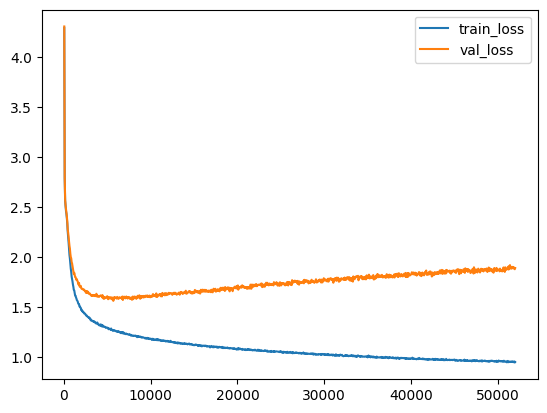

In [200]:
import matplotlib.pyplot as plt
plt.plot(df['iter'], df['train_loss'], label='train_loss')
plt.plot(df['iter'], df['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [201]:
df = pd.read_csv('loss.csv', index_col=False)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([8, 9])